In [48]:
%reload_ext autoreload
%autoreload 2

In [49]:
import os
import glob
import random
import numpy as np
from PIL import Image
from IPython.display import display
from IPython.display import Image as DisplayImage
import torch

from nnext import NNextClient
from nnext.http.models import Distance
from nnext.conversions.common_types import Record
from nnext.http.models import Filter, FieldCondition

from custom_resnet18 import TorchVisionResNet18
from feature_extractor import FeatureExtractor

In [50]:
# Connect to NNext
nnclient = NNextClient(host="0.0.0.0", port="6040")
nnclient.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='shoes_collection')])

In [51]:
# Load fine tuned resnet CNN (this model was fine tuned with shoes dataset in Resnet_finetuning.ipynb)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = TorchVisionResNet18()
model.load_state_dict(torch.load("resnet_checkpoint.pth", map_location=torch.device("cpu")))

<All keys matched successfully>

In [52]:
FEATURE_VEC_LEN = 512 # avgpool layer width
feature_extractor = FeatureExtractor(model, FEATURE_VEC_LEN)

In [53]:
train_path = "./data/train/"
feature_vectors = feature_extractor.encode_train_images(train_path)

In [54]:
# Create shoes collection
COLLECTION_NAME = "shoes_collection"

nnclient.recreate_collection(
    collection_name=COLLECTION_NAME,
    vector_size=FEATURE_VEC_LEN,
    distance=Distance.COSINE
)
nnclient.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='shoes_collection')])

In [55]:
# Inserts encoded images to NNext DB

def create_metadata(img_path, brand):
	return {
	      "img_path": img_path,
          "brand": brand
	  }

records = [
        Record(
            id=idx,
            vector=feature_vec["feature_vec"],
            payload=create_metadata(feature_vec["img_path"], feature_vec["brand"])
        )
        for idx, feature_vec in enumerate(feature_vectors)
    ]

nnclient.upload_records(
        collection_name=COLLECTION_NAME,
        records=records,
        parallel=2
    )

2022-09-15 18:25:36.375 | INFO     | nnext.parallel_processor:_worker:47 - Reader worker: 0 PID: 57575
2022-09-15 18:25:36.375 | INFO     | nnext.parallel_processor:_worker:47 - Reader worker: 1 PID: 57576
2022-09-15 18:25:37.130 | INFO     | nnext.parallel_processor:_worker:79 - Reader worker 0 finished
2022-09-15 18:25:37.251 | INFO     | nnext.parallel_processor:_worker:79 - Reader worker 1 finished


In [56]:
# Search 4 recommendations per brand

searches = {"adidas": {}, "nike": {}, "converse": {}}

for brand in searches.keys():
    test_dir = f"./data/test/{brand}/"
    test_filename = random.choice(os.listdir(test_dir))
    test_img_path = test_dir + test_filename

    with torch.no_grad():
        img = Image.open(test_img_path)
        feature_vec = feature_extractor.extract_feature_vector(img).tolist()

    _brand_filter = Filter(
            must=[
                FieldCondition(
                    key="brand",
                    match={"value": brand}
                )
            ]
        )

    shoes_search = nnclient.search(
        collection_name=COLLECTION_NAME,
        query_vector=feature_vec,
        query_filter=_brand_filter,
        append_payload=True,
        limit=4
    )

    searches[brand] = {
                        "test_img_path": test_img_path,
                        "search": shoes_search,
                        "brand": brand 
                      }
    

In [57]:
def display_recommendations(search):
    print("Recommended shoes")
    img_1 = DisplayImage(filename=search[0].payload["img_path"])
    img_2 = DisplayImage(filename=search[1].payload["img_path"])
    img_3 = DisplayImage(filename=search[2].payload["img_path"])
    img_4 = DisplayImage(filename=search[3].payload["img_path"])
    display(img_1, img_2, img_3, img_4)

### Adidas recommendation

Test image


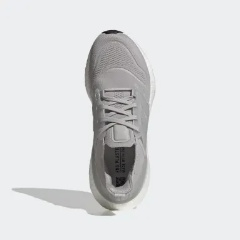

In [58]:
print("Test image")
test_img = display(DisplayImage(filename=searches["adidas"]["test_img_path"]))

Recommended shoes


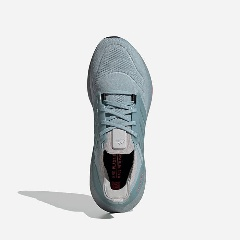

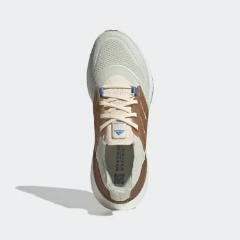

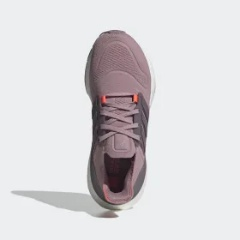

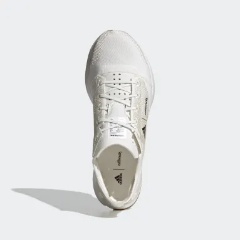

In [59]:
display_recommendations(searches["adidas"]["search"])

### Nike recommendation

Test image


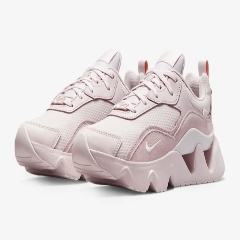

In [60]:
print("Test image")
test_img = display(DisplayImage(filename=searches["nike"]["test_img_path"]))

Recommended shoes


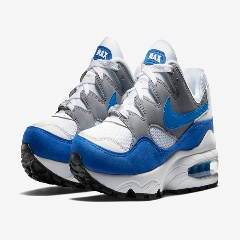

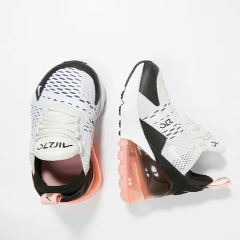

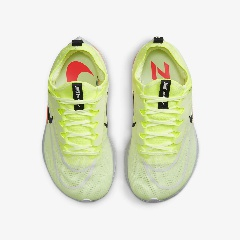

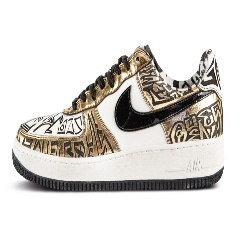

In [61]:
display_recommendations(searches["nike"]["search"])

### Converse recommendation

Test image


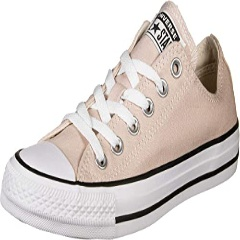

In [62]:
print("Test image")
test_img = display(DisplayImage(filename=searches["converse"]["test_img_path"]))

Recommended shoes


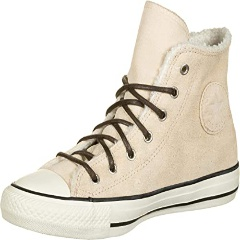

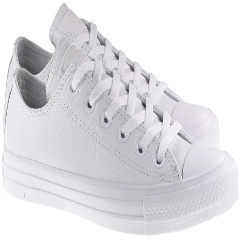

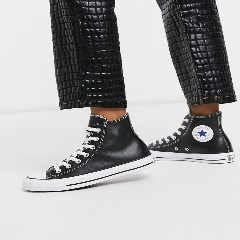

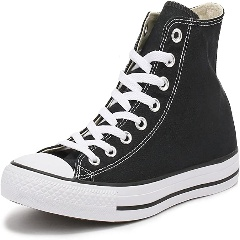

In [63]:
display_recommendations(searches["converse"]["search"])